# CSC11 - Introduction to Machine Learning - A1 - Q2

## Image Denoising with RBF Rgression
Image Denoising is a long-standing problem in areas of signal processing and computer vision.
The measurements in physical processes are typically noisy and noise removal is a crucial step to
obtain the underlying ground-truth signal.
In this notebook, you are going to use the radial basis regression model that you implemented in the start code, and denoise an input image corrupted by salt-and-pepper noise. You will try different settings of widths of RBFs and their spacings to see their effects. 
The result of these experiments are visualized using `matplotlib` library.
The goal is to describe the plots, characterize overfitting/undefitting scenarios and explain them.

**Note:** You don't need to change/write any code in the notebook. After each part, you see the questions that you need to answer. Please provide you answer in the markdown cells and share the noteboook.

In [6]:
# initial imports

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from rbf_regression import RBFRegression

### Load Image
First we use `Pillow` library to read the image. To reduce later computations, we resize the image by a factor of two yielding an image of size 384x256.

In [7]:
# Read the Image
image_name = './a1q2.jpg'
img = Image.open(image_name)
img = img.resize((img.size[0] // 2, img.size[1] // 2))
img = np.array(img) / 255 
img = img.astype(np.float32)

## Salt-and-pepper noise

Image Denoising is a long-standing problem in areas of signal processing and computer vision.
The measurements in physical processes are typically noisy and noise removal is a crucial step to
obtain the underlying ground-truth signal. In this question, we aim to deal with the salt-and-pepper
noise. 
With `salt_prob` any pixel changes to white pixel, namely `salt_rgb=(255,255,255)`.
With `pepper_prob` any pixel changes to black pixel, namely `salt_rgb=(0,0,0)`.
This noise appears as sparsely occurring white and black pixels as shown in the visualization. 
We simulate this noise for the load image:

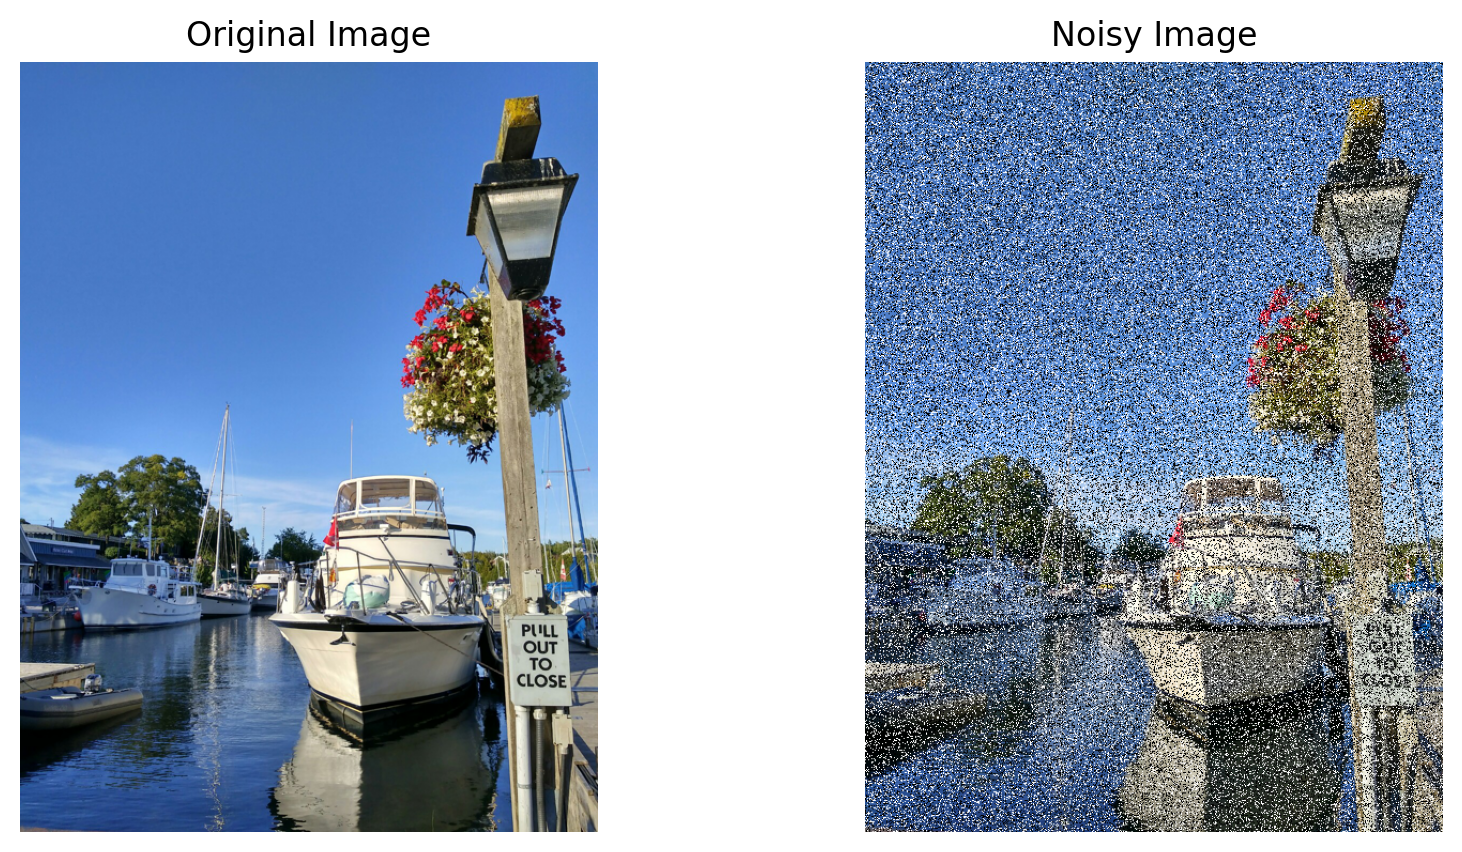

In [8]:
pepper_rgb = np.array([0, 0, 0])
pepper_rgb = pepper_rgb.astype(np.float32) / 255
salt_rgb = np.array([255, 255, 255])
salt_rgb = salt_rgb.astype(np.float32) / 255

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    
    # Add salt noise
    salt_pixels = np.random.rand(*image.shape[:-1]) < salt_prob
    noisy_image[salt_pixels] = 1

    # Add pepper noise
    pepper_pixels = np.random.rand(*image.shape[:-1]) < pepper_prob
    noisy_image[pepper_pixels] = 0

    return noisy_image

noisy_img = add_salt_and_pepper_noise(img, 0.2, 0.2)
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(noisy_img)
axs[1].set_title('Noisy Image')
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

## Denoising function

Next, the `denoising` function is defined. This function takes in an image and then split it into individual patches of size `patch_size`. The function iterates through image patches and a separate RBF model is fitted in a regularized fashion (with `l2_coeff` as $lambda$) to each patch. The centers of RBF are placed with even spacing of `spacing` and same widths of `width`.

In [9]:
def denoising(im, spacing, width, patch_size, l2_coeff, tolerance):
    im_rec = im.copy() # reconstruction or denoised
    H, W = im.shape[:2]

    # i corresponds to left-to-right
    # j corresponds to up-to-down
    for i in range(0, W-patch_size+1, patch_size):
        for j in range(0, H-patch_size+1, patch_size):
            # Grid of pixel coordinates in the patch
            XX, YY = np.meshgrid(np.arange(i, i+patch_size), np.arange(j, j+patch_size))
            P = np.stack([YY, XX], axis=0).reshape(-1, 2)
            
            # Uses squared distance to find indcies to be filled
            patch = im[j:j+patch_size, i:i+patch_size]
            ref1 = ((patch - salt_rgb) ** 2).sum(axis=2)
            ref2 = ((patch - pepper_rgb) ** 2).sum(axis=2)
            cond = np.logical_or(ref1 <= tolerance, ref2 <= tolerance)
            index_fill = np.argwhere(cond) # if close to fill_rgb, then fill
            index_data = np.argwhere(~cond) # if not close to fill_rgb, then data
            idx_data = np.sort(index_data[:,1]*ref1.shape[0]+index_data[:,0])
            idx_fill = np.sort(index_fill[:,1]*ref1.shape[0]+index_fill[:,0])

            # Place RBFs over image patch with even spacing and same widths
            XX, YY = np.meshgrid(list(range(i, i+patch_size, spacing)),
                                list(range(j, j+patch_size, spacing)))

            centers = np.array((XX.flatten(), YY.flatten()), dtype=np.float32).T
            num_centers = centers.shape[0]
            widths = np.ones(shape=(num_centers, 1), dtype=np.float32) * width

            # Construct one model for each color channel
            red_model = RBFRegression(centers=centers, widths=widths)
            green_model = RBFRegression(centers=centers, widths=widths)
            blue_model = RBFRegression(centers=centers, widths=widths)
            
            # If there are pixels that need to be filled, then we try to train the models and fill.
            # Otherwise, we use the original patch
            if (idx_fill.size>0):
                # print('Reconstructing patch at selected color')
                if(idx_data.size <= num_centers):
                    # print('Not enough pixels to estimate RBF model! copying patch\n')
                    patch_rec = patch.copy()
                else:
                    # Valid locations for sampling pixels
                    P_data = P[idx_data]

                    # Reconstruct each colour layer using a separate RBF model
                    # Red channel
                    patch_R = patch[:,:,0]
                    z_R = patch_R.reshape(patch_R.size, 1, order='F')
                    z_R = z_R[idx_data]
                    red_model.fit_with_l2_regularization(P_data, z_R, l2_coeff)
                    
                    # Green channel
                    patch_G = patch[:,:,1]
                    z_G = patch_G.reshape(patch_G.size, 1, order='F')
                    z_G = z_G[idx_data]
                    green_model.fit_with_l2_regularization(P_data, z_G, l2_coeff)
                    
                    # Blue channel
                    patch_B = patch[:,:,2]
                    z_B = patch_B.reshape(patch_B.size, 1, order='F')
                    z_B = z_B[idx_data]
                    blue_model.fit_with_l2_regularization(P_data, z_B, l2_coeff)
                    
                    # Reconstruct pixel values at fill-in locations
                    P_fill = P[idx_fill]
                    fill_R = red_model.predict(P_fill)
                    fill_G = green_model.predict(P_fill)
                    fill_B = blue_model.predict(P_fill)
                    
                    # Assemble reconstructed patch
                    patch_rec = patch.copy()
                    patch_rec[index_fill[:,0], index_fill[:,1], 0] = np.squeeze(np.asarray(fill_R)) # Red
                    patch_rec[index_fill[:,0], index_fill[:,1], 1] = np.squeeze(np.asarray(fill_G)) # Green
                    patch_rec[index_fill[:,0], index_fill[:,1], 2] = np.squeeze(np.asarray(fill_B)) # Blue
            else:
                # print('Copying patch at %d--%d\n'%(i,j))
                patch_rec = patch.copy()
            im_rec[j:j+patch_size, i:i+patch_size] = patch_rec
    im_rec = np.clip(im_rec, 0, 1)
    return im_rec

### Denoising in default setting
Using the above function, we run the denoiser in a default setting. The output is visualized and compared with the input and the clean image.

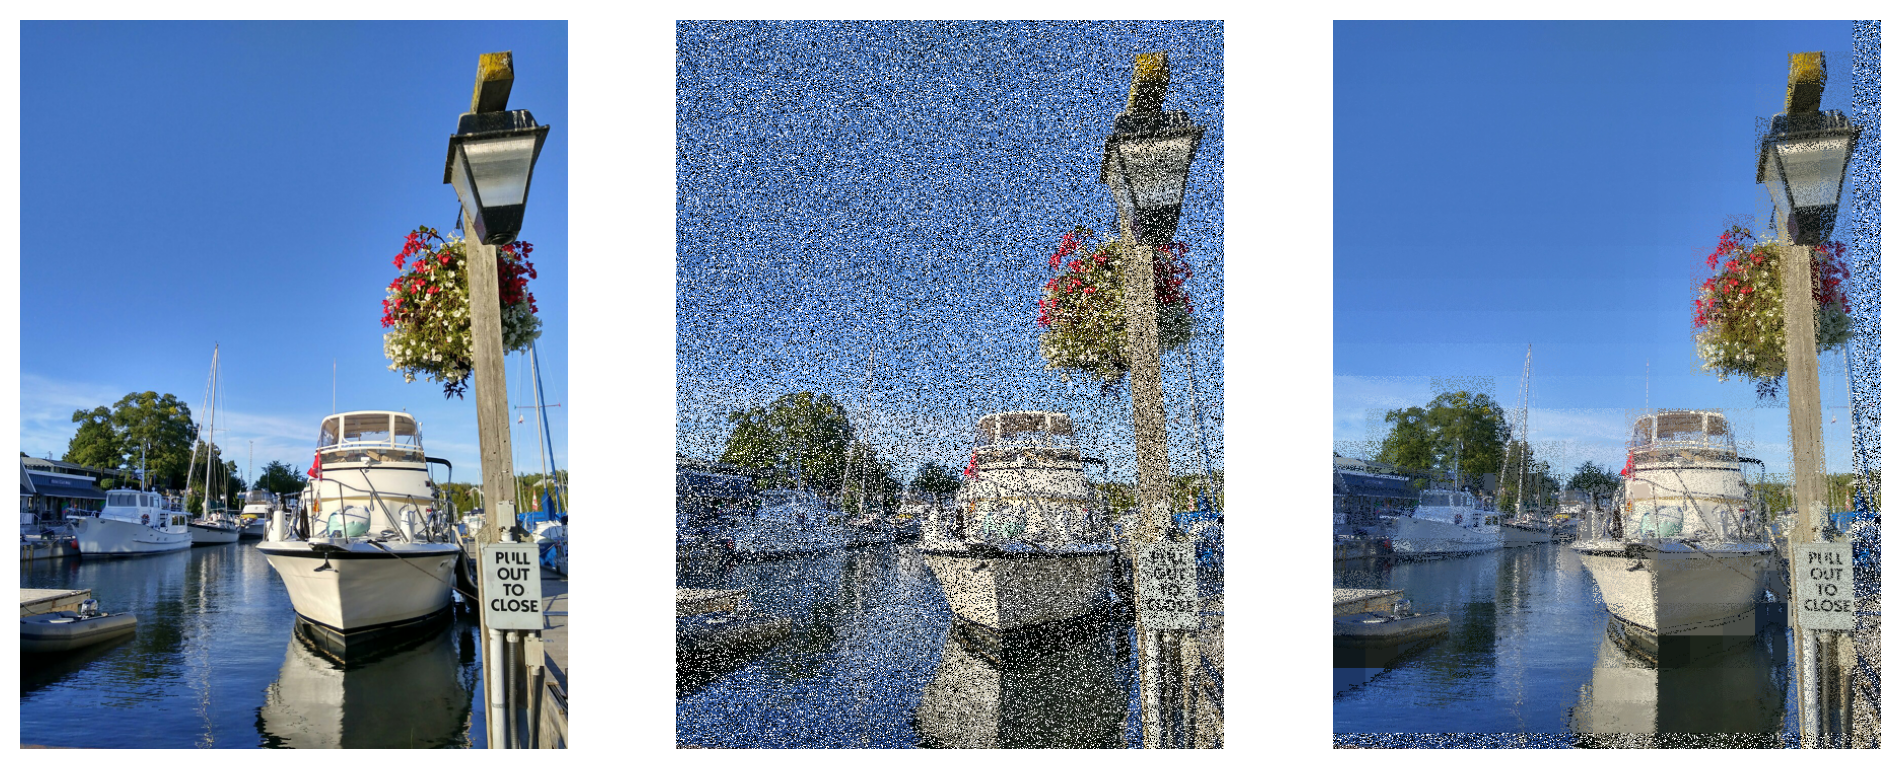

In [10]:
l2_coef = 2
tolerance = 0.01
spacing = 16 # 1 <= spacing <= 9
width = 4 # 1 <= width <= 2 * spacing
patch_size = 32 # >=1
img_recs = []
img_rec = denoising(noisy_img, 
                    spacing=spacing, width=width, 
                    patch_size=patch_size, l2_coeff=l2_coef, 
                    tolerance=tolerance)
fig, axs = plt.subplots(1, 3, figsize=(12, 5), dpi=200)
axs[0].imshow(img)
axs[1].imshow(noisy_img)
axs[2].imshow(img_rec)
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()
plt.show()

**Question:**
Does the denoiser perform well? Do you see any artifacts in the denoised image? What are the potential reasons for these artifacts?

**Answer:**
Yes, the denoiser perform quite well. However, we still can notice that there are some artifacts in the denoised image, compared to the noiseless image. In particulaar, some part of the denoised image gets blurred whereas some other part still has remaining salt-and-pepper noise artifacts.
There are some potential reasons for these artifacts:
- It;s possible that blurred artifacts in denoising may occur when the model overly averages or smooths out the pixels. As a result, the model loses fine details, edges, and textures in the image. Moreover, using overly strong regularization can force the model to smooth out small variations, leading to a blurry image.
- The remaining salt-and-pepper noise can happen due to very high noise density or when the regularization is too weak, it might not sufficiently penalize the noise.
- In some cases, the edges or isolated areas of an image might be more difficult to process which can leave localized noise behind after denoising. Hence why in the denoised image that we generate, the edges/corner (right and bottom part) and the isolated part of the image (such as the isolated part of the boat) have more remaining salt-and-pepper noise compared to other region.

## Effect of width

Given a certain `spacing=16`, we run denoising with various widths, raning from 1 to `spacing/2`.
Then the mean squared error is computed between denoised and clean image. The error is visualized as a function of the width size. 
Note that running the experiments could take a few seconds.

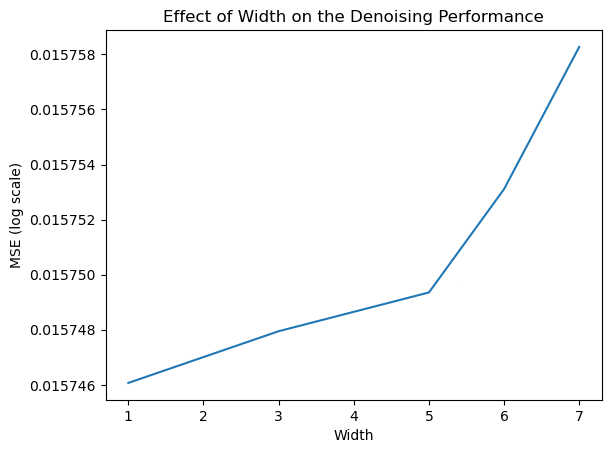

In [13]:
l2_coef = 2.5
tolerance = 0.01

spacing = 16
patch_size = 32
mses = []
widths = np.arange(1, spacing//2).astype(np.int32)
for width in widths:
    img_rec = denoising(noisy_img, 
                        spacing=spacing, width=width, 
                        patch_size=patch_size, l2_coeff=l2_coef, 
                        tolerance=tolerance)
    mse = ((img_rec - img)**2).mean()
    mses.append(mse)
plt.plot(widths, np.log(1+np.array(mses)))
plt.xlabel('Width')
plt.ylabel('MSE (log scale)')
plt.title('Effect of Width on the Denoising Performance')
plt.show()

**Question:**
How does the error change when increasing the width? Justify your answer.

**Answer:**
Based on the graph of the effect of width on the denoising performance, we observe that the MSE increases as the width increases. A large width results in each RBF becomes broader, meaning the RBF influences a larger area. When the width is too large, each RBF affects a large region of the data, causing the model to lose fine details and over-smooth the complexity of the image, leading to model becoming too simple and underfit. With a large width, RBFs become too similar to each other (because their influence overlaps significantly). As a result, the model can not adapt well to the underlying data structure, leading to higher MSE.


## Effect of spacing
Given a fixed `width=3`, we run denoising with various spacings, ranging from `width` to `width*4+1`. Here the goal is to explore the effect of the spacing between basis functions. As before, the mean squared error is computed and visualized.
Note that running the experiments could take a few seconds.

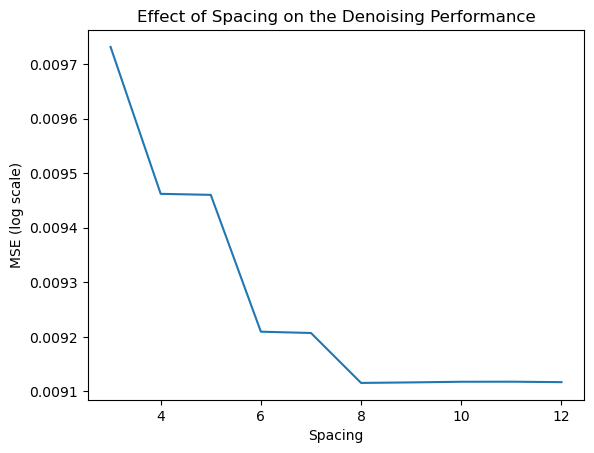

In [12]:
l2_coef = 2.0
tolerance = 0.01

width = 3
patch_size = 16
mses = []
spacings = np.arange(width, width*4+1).astype(np.int32)
for spacing in spacings:
    img_rec = denoising(noisy_img, 
                        spacing=spacing, width=width, 
                        patch_size=patch_size, l2_coeff=l2_coef, 
                        tolerance=tolerance)
    mse = ((img_rec - img)**2).mean()
    mses.append(mse)
plt.plot(spacings, np.log(1+np.array(mses)))
plt.xlabel('Spacing')
plt.ylabel('MSE (log scale)')
plt.title('Effect of Spacing on the Denoising Performance')
plt.show()

**Question:**
Discuss how the error changes when increasing the spacing. Justifications are required.

**Answer:**
Based on the graph of the effect of spacing on the denoising performance, the MSE (log scale) decreases as spacing increases to a certain point (e.g. 8 on the graph), and remains the same afterward. This due to the fact that when spacing is large, the RBFs are spaced far apart and the RBFs are able cover the domain more evenly which help in getting better generalization and avoiding redundancy. Thus, allowing each RBF to contribute meaningfully to the model with out too much overlaps.